In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/MyDrive/DL/Final_Project/

/content/drive/MyDrive/DL/Final_Project


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device in use:',device)

Device in use: cuda


In [ ]:
def get_mnist_dataloader(batch_size=64, shuffle=True,model='teacher'):
    # Define the data transformation
    if model == 'teacher':
      transform_train = transforms.Compose([
          transforms.ToTensor(),  # Convert images to PyTorch tensors
          transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to the range [-1, 1]
          transforms.RandomAffine(0,(0.2,0.2))
      ])
    else:
      transform_train = transforms.Compose([
          transforms.ToTensor(),  # Convert images to PyTorch tensors
          transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to the range [-1, 1]
      ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to the range [-1, 1]

    ])

    # Download MNIST dataset
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

    # Create data loaders
    train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

## get the training, validation and testing datasets
teacher_train_loader, test_loader = get_mnist_dataloader(batch_size=64, shuffle=True,model='teacher')
student_train_loader, test_loader = get_mnist_dataloader(batch_size=64, shuffle=True,model='student')

In [ ]:
## general training function
def train_model(model,optimizer,criterion,model_name,train_loader,epochs,t=1):
  train_losses, train_accs = [],[]
  teacher = {}
  teacher['T'] = t
  ## keep track of acc to save the best model
  best_acc = 0

  for epoch in range(epochs):
    print(f"----------------------------------EPOCH {epoch}--------------------------------------")
    train_loss = 0
    total_examples = 0
    correct_examples = 0
    model.train()
    ## model training
    for inputs, targets in train_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      model_outputs = model(inputs)
      output_predictions = torch.argmax(model_outputs, dim=1)
      model_outputs /= t
      model_loss = criterion(model_outputs, targets)
      model_loss.backward()
      optimizer.step()

      train_loss += model_loss.item()
      correct_examples += torch.sum((output_predictions==targets))
      total_examples += targets.size(0)
    ## compute the average training loss/acc for the epoch

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print("\n Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    ## save the best model
    if avg_acc > best_acc:
      best_acc = avg_acc
      torch.save(model.state_dict(), model_name)
      print('Saving model....')

  ## save the results
  teacher['train loss'] = train_losses
  teacher['train accs'] = train_accs
  teacher['best acc'] = best_acc

  ## plot the learning curve for training/validation
  plt.plot(np.arange(1,epochs+1),np.array(train_losses),label='training curve')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Curves')

  return teacher


In [ ]:
def test_model(test_model,teacher):
  correct_examples = 0
  total_examples = 0
  test_model.eval()

  with torch.no_grad():
      for test_data, test_labels in test_loader:
          # Assuming your_model is your trained neural network
          test_data=test_data.to(device)
          test_labels=test_labels.to(device)
          output_predictions = test_model(test_data)

          # Calculate accuracy
          _, predicted = torch.max(output_predictions, 1)
          correct_examples += (predicted == test_labels).sum().item()
          total_examples += test_labels.size(0)

  accuracy = correct_examples / total_examples
  print(f"Accuracy: {accuracy * 100:.2f}%")
  print("\nCorrect:",correct_examples)
  print("\nTotal:",total_examples)
  teacher['correct'] = correct_examples
  teacher['test acc'] = accuracy

## Visualiza some of the training data

Batch shape: torch.Size([64, 1, 28, 28])


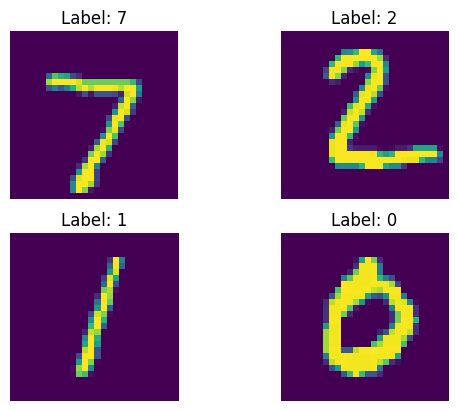

In [ ]:

for data, labels in test_loader:
    print('Batch shape:',data.shape)
    ## plot the images
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(data[i].reshape(28, 28))
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')
    plt.show()
    break

## Design the teacher model:
1. Number of hidden layers = 2 of 1200 hidden units
2. dropout = 50% for the hidden units and 20% for the input pixels
3. learning rate = 0.001


In [ ]:
## design the large network
## not a conv network
class parent(nn.Module):
  def __init__(self):
    super(parent, self).__init__()
    self.linear1 = nn.Linear(28*28, 1200)
    self.linear2 = nn.Linear(1200,1200)
    self.linear3 = nn.Linear(1200, 10)
    self.dropout_hidden = nn.Dropout(0.5)
    self.dropout_visible = nn.Dropout(0.2)

  def forward(self,x):
    flatten = x.view(x.size(0),-1)
    x = self.dropout_visible(flatten)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.dropout_hidden(x)
    x = self.linear3(x)
    return x

### change optimizer to ADAM and run this

In [ ]:
# Training the Larger Network
larger_net = parent()
larger_net = larger_net.to(device)
optimizer_large = optim.SGD(larger_net.parameters(), lr=0.01, momentum=0.9, weight_decay = 1e-5)
criterion_large = nn.CrossEntropyLoss()

In [ ]:
teacher_dict = train_model(larger_net,optimizer_large,criterion_large,'teacher.pth',teacher_train_loader,50,1)

## Test the accuracy for the teacher model

In [ ]:
teacher_model = parent()
teacher_model = teacher_model.to(device)
optimizer_large = optim.SGD(teacher_model.parameters(), lr=0.01, momentum=0.9)
criterion_large = nn.CrossEntropyLoss()
teacher_model.load_state_dict(torch.load('teacher.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
teacher_dict = {}
test_model(teacher_model,teacher_dict)

Accuracy: 98.13%

Correct: 9813

Total: 10000


## Design the student model:
1. Number of hidden layers = 2 of 800 hidden units
2. no regularization
3. learning rate = 0.01


In [ ]:
## design the small network
## not a conv network
class student(nn.Module):
  def __init__(self):
    super(student, self).__init__()
    self.linear1 = nn.Linear(28*28, 30)
    self.linear2 = nn.Linear(30,30)
    self.linear3 = nn.Linear(30, 10)

  def forward(self,x):
    flatten = x.view(x.size(0),-1)
    x = F.relu(self.linear1(flatten))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

## change optimizer and run

In [ ]:
# Training the smaller Network
smaller_net = student()
smaller_net = smaller_net.to(device)
optimizer_small = optim.SGD(smaller_net.parameters(), lr=0.01, momentum=0.9)
criterion_small = nn.CrossEntropyLoss()

----------------------------------EPOCH 0--------------------------------------

 Training loss: 0.4869, Training accuracy: 0.8468
Saving model....
----------------------------------EPOCH 1--------------------------------------

 Training loss: 0.2351, Training accuracy: 0.9285
Saving model....
----------------------------------EPOCH 2--------------------------------------

 Training loss: 0.1864, Training accuracy: 0.9434
Saving model....
----------------------------------EPOCH 3--------------------------------------

 Training loss: 0.1621, Training accuracy: 0.9500
Saving model....
----------------------------------EPOCH 4--------------------------------------

 Training loss: 0.1469, Training accuracy: 0.9557
Saving model....
----------------------------------EPOCH 5--------------------------------------

 Training loss: 0.1370, Training accuracy: 0.9568
Saving model....
----------------------------------EPOCH 6--------------------------------------

 Training loss: 0.1291, Trainin

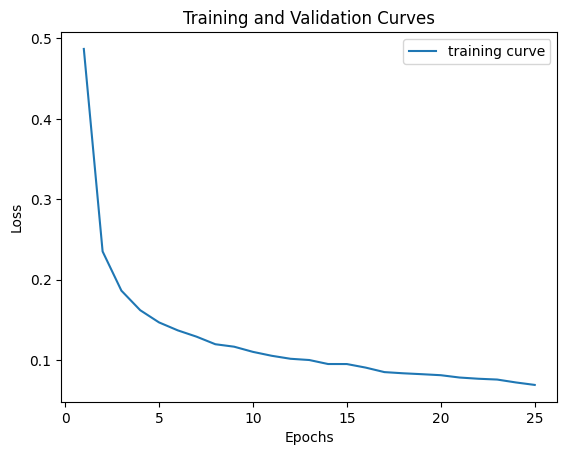

In [ ]:
train_model(smaller_net,optimizer_small,criterion_small,'student30.pth',student_train_loader)

In [ ]:
student_model = student()
student_model = student_model.to(device)
student_model.load_state_dict(torch.load('student30.pth'))

<All keys matched successfully>

In [ ]:
test_model(student_model)

Accuracy: 96.37%

Correct: 9637

Total: 10000


## DISTILLATION WITH KD LOSS

In [ ]:
# Training the smaller Network
distilled_net = student()
distilled_net = distilled_net.to(device)
optimizer = optim.SGD(distilled_net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
T = 1
alpha = 0.5

In [ ]:
best_acc = 0
for epoch in range(0,25):
  print(f'Epoch{epoch}')
  train_loss = 0
  correct_examples = 0
  total_examples = 0
  for inputs, targets in student_train_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()

      student_targets = distilled_net(inputs)  ## student softmax values
      teacher_targets = teacher_model(inputs) ## teacher softmax values
      print(student_targets)

      loss = F.kl_div(F.log_softmax(student_targets / T, dim=1), F.softmax(teacher_targets / T, dim=1), reduction='batchmean') * (T ** 2) * alpha + criterion(student_targets, targets) * (1 - alpha)
      output_predictions = torch.argmax(student_targets, dim=1)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      correct_examples += torch.sum((output_predictions==targets))
      total_examples += targets.numel()
  avg_loss = train_loss / len(student_train_loader)
  avg_acc = correct_examples / total_examples

  ## save the best model
  if avg_acc > best_acc:
    best_acc = avg_acc
    torch.save(distilled_net.state_dict(), 'distilled0.pth')
    print('Saving model....')
  print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

In [ ]:
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled0.pth'))

<All keys matched successfully>

In [ ]:
test_model(distilled_net)


Accuracy: 96.59%

Correct: 9659

Total: 10000


## DISTILLATION WITH CE LOSS

In [ ]:
# Training the smaller Network
distilled_net = student()
distilled_net = distilled_net.to(device)
optimizer = optim.SGD(distilled_net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
alpha = 0.5
T = 3

In [ ]:
best_acc = 0
for epoch in range(0,25):
  print(f'Epoch{epoch}')
  train_loss = 0
  correct_examples = 0
  total_examples = 0
  for inputs, targets in student_train_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()

      student_targets = distilled_net(inputs)  ## student softmax values
      #student_targets += 1e-5 ## to avoid stopping the trianing
      #student_targets /= T   ## the input to softmax function becomes z/T - adding the temperature
      teacher_targets = teacher_model(inputs) ## teacher softmax values
      teacher_predictions = torch.argmax(teacher_targets,dim=1)
      #loss = alpha*(criterion(student_targets,teacher_predictions)) + (1-alpha)*(criterion(student_targets,targets))
      loss = alpha*F.cross_entropy(student_targets/T, F.softmax(teacher_targets/T,dim=1))*(T**2) + F.cross_entropy(student_targets, targets)

      output_predictions = torch.argmax(student_targets, dim=1)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      correct_examples += torch.sum((output_predictions==targets))
      total_examples += targets.numel()
  avg_loss = train_loss / len(student_train_loader)
  avg_acc = correct_examples / total_examples

  ## save the best model
  if avg_acc > best_acc:
    best_acc = avg_acc
    torch.save(distilled_net.state_dict(), 'distilled50_t10_ce.pth')
    print('Saving model....')
  print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

Epoch0
Saving model....
Training loss: 4.7524, Training accuracy: 0.8751
Epoch1
Saving model....
Training loss: 3.9774, Training accuracy: 0.9403
Epoch2
Saving model....
Training loss: 3.8921, Training accuracy: 0.9504
Epoch3
Saving model....
Training loss: 3.8241, Training accuracy: 0.9560
Epoch4
Saving model....
Training loss: 3.8023, Training accuracy: 0.9580
Epoch5
Saving model....
Training loss: 3.7817, Training accuracy: 0.9606
Epoch6
Saving model....
Training loss: 3.7596, Training accuracy: 0.9621
Epoch7
Saving model....
Training loss: 3.7477, Training accuracy: 0.9640
Epoch8
Training loss: 3.7562, Training accuracy: 0.9632
Epoch9
Saving model....
Training loss: 3.7258, Training accuracy: 0.9662
Epoch10
Saving model....
Training loss: 3.7262, Training accuracy: 0.9667
Epoch11
Saving model....
Training loss: 3.7167, Training accuracy: 0.9682
Epoch12
Training loss: 3.7165, Training accuracy: 0.9676
Epoch13
Saving model....
Training loss: 3.7052, Training accuracy: 0.9686
Epoch14


In [ ]:
curr = {}

In [ ]:
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled50_t10_ce.pth', map_location='cpu'))
test_model(distilled_net,curr)

Accuracy: 96.60%

Correct: 9660

Total: 10000


In [ ]:
test_model(distilled_net)

Accuracy: 96.50%

Correct: 9650

Total: 10000


perform distillation here with the new teacher and include the same optimizations here

In [ ]:
from tqdm import tqdm

In [ ]:
t = 5
alpha = [1,0.75,0.5,0.25]
epochs = 25
grid_results = []

In [ ]:
for a in tqdm(alpha):
  current_grid = {}
  current_grid['alpha'] = a
  current_grid['T'] = t
  model_name = 'distilled_A'+str(a)+ '_T' + str(t) + '.pth'

  ## instantiate a new student model for distillation
  distilled_net = student()
  distilled_net = distilled_net.to(device)
  optimizer = optim.SGD(distilled_net.parameters(), lr=0.01, momentum=0.9)
  criterion = nn.CrossEntropyLoss()

  ## start the training process
  best_val_acc = 0
  train_losses = []
  val_accs = []
  train_accs = []
  for epoch in range(0,epochs):
    train_loss = 0
    correct_examples = 0
    total_examples = 0
    distilled_net.train()
    for inputs, targets in student_train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()

        student_targets = distilled_net(inputs)  ## student softmax values
        #student_targets /= t   ## the input to softmax function becomes z/T - adding the temperature
        teacher_targets = teacher_model(inputs) ## teacher softmax values
        #teacher_predictions = torch.argmax(teacher_targets,dim=1)
        loss = a*F.cross_entropy(student_targets/t, F.softmax(teacher_targets/t,dim=1))*(t**2) + F.cross_entropy(student_targets, targets)*(1-a)

        output_predictions = torch.argmax(student_targets, dim=1)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct_examples += torch.sum((output_predictions==targets))
        total_examples += targets.numel()

    avg_loss = train_loss / len(student_train_loader)
    avg_acc = correct_examples / total_examples
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)

    distilled_net.eval()
    with torch.no_grad():
      for test_data, test_labels in test_loader:
          # Assuming your_model is your trained neural network
          test_data=test_data.to(device)
          test_labels=test_labels.to(device)
          output_predictions = distilled_net(test_data)

          # Calculate accuracy
          _, predicted = torch.max(output_predictions, 1)
          correct_examples += (predicted == test_labels).sum().item()
          total_examples += test_labels.size(0)

    #avg_loss = train_loss / len(student_train_loader)
    avg_acc = correct_examples / total_examples
    val_accs.append(avg_acc)
    ## save the best model
    if avg_acc > best_val_acc:
      best_val_acc = avg_acc
      torch.save(distilled_net.state_dict(), model_name)
    #print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

  ## save the results
  current_grid['best accuracy'] = best_val_acc
  current_grid['train loss'] = train_losses
  current_grid['train accs'] = train_accs

  grid_results.append(current_grid)




100%|██████████| 4/4 [29:41<00:00, 445.33s/it]


In [ ]:
file = open('t4_results.txt','w')
for result in grid_results:
	file.write(str(result)+"\n")
file.close()


## testing models

In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A1_T5.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 95.88%

Correct: 9588

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A0.25_T5.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 96.98%

Correct: 9698

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A0.75_T5.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 96.15%

Correct: 9615

Total: 10000


In [ ]:
curr = {}
distilled_net = student()
distilled_net = distilled_net.to(device)
distilled_net.load_state_dict(torch.load('distilled_A0.5_T5.pth',map_location=torch.device('cuda')))
test_model(distilled_net,curr)

Accuracy: 96.94%

Correct: 9694

Total: 10000


previous results

In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A1_T25.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.00%

Correct: 9600

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A1_T2.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.32%

Correct: 9632

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A1_T1.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.30%

Correct: 9630

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0_T1.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 95.10%

Correct: 9510

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0_T2.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.65%

Correct: 9665

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0_T25.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.98%

Correct: 9698

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0_T3.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.93%

Correct: 9693

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0_T35.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 97.05%

Correct: 9705

Total: 10000


In [ ]:
  distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0_T4.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.55%

Correct: 9655

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.5_T4.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.69%

Correct: 9669

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.5_T35.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.71%

Correct: 9671

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.5_T3.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 97.01%

Correct: 9701

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.5_T25.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 97.08%

Correct: 9708

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.5_T2.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.97%

Correct: 9697

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.5_T1.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.69%

Correct: 9669

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.75_T1.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.76%

Correct: 9676

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.75_T2.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.78%

Correct: 9678

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.75_T25.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.59%

Correct: 9659

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.75_T3.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.59%

Correct: 9659

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.75_T35.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 97.06%

Correct: 9706

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.75_T4.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.87%

Correct: 9687

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.25_T4.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.90%

Correct: 9690

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.25_T35.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 97.05%

Correct: 9705

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.25_T3.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.85%

Correct: 9685

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.25_T25.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.99%

Correct: 9699

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.25_T2.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.94%

Correct: 9694

Total: 10000


In [ ]:
distilled_net = student()
distilled_net.load_state_dict(torch.load('distilled_A0.25_T1.pth',map_location=torch.device('cpu')))
test_model(distilled_net,curr)

Accuracy: 96.90%

Correct: 9690

Total: 10000
